In [3]:
%matplotlib inline
import torchfilter as tfilter
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
import torch
from collections import namedtuple

In [4]:
import os, sys
sys.path.append('.')

from dynamics_models import *
from kf_measurement_models import *
from pf_measurement_models import *
from virtual_sensor_models import *
from utils import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Configuration parameters wrapped into a named tuple

Config = namedtuple("Config", "state_dim observation_dim control_dim A B Q pr_std idx")
Index = namedtuple("Index", "x y z b")

def create_config():
    state_dim = 8
    observation_dim = 10
    control_dim = 3
    idx = Index(0, 1, 2, 3)

    A = torch.eye(state_dim)
    
    for i in range(4):
        A[i, 4+i] = 0.1
    Q = torch.eye(state_dim) * 0.1
    
    B = torch.zeros(state_dim, control_dim)
    B[4:7, :] = torch.eye(control_dim)

    pr_std = 1.0
    
    return Config(state_dim, observation_dim, control_dim, A, B, Q, pr_std, idx)

config = create_config()

In [6]:
dynamics_model = MyDynamicsModel(config)
kf_measurement_model = GNSSKFMeasurementModel(config)
vsensor_model = GNSSVirtualSensorModel(config, iterations=10, convergence=1e-3)
pf_measurement_model = GNSSPFMeasurementModelA(config)

In [9]:
# init_state = torch.nn.Parameter(torch.zeros(config.state_dim)).expand((1, config.state_dim))
Data = namedtuple("Data", "observations controls gt satellite_states N_observations")
def generate_data(config):
    T = 20
    times = torch.arange(T)
    states = torch.zeros(T, config.state_dim)
#     controls = torch.zeros(T, config.control_dim)
    controls = torch.stack([torch.sin((2*np.pi/T)*times*k) for k in range(config.control_dim)]).T
    observations = torch.zeros(T, config.observation_dim)
    satellite_states = (torch.rand(T, config.observation_dim, 4) - 0.5)*2e7
    satellite_states[:, :, 3] = torch.rand(T, config.observation_dim)*1e3
    satellite_states[:, :, 2] = torch.rand(T, config.observation_dim)*1e3 + 1e7
    N_observations = torch.zeros(T, dtype=torch.int)
    
    for t in range(1, T):
#         controls[t, :] = torch.randn(config.control_dim)
        next_state, Q = dynamics_model(states[t-1, :][None, :], controls[t, :][None, :])
        states[t, :] = next_state.squeeze(0) + batched_mm(Q, torch.randn((1, config.state_dim))).squeeze(0)
        N_observations[t] = 4 + np.random.randint(config.observation_dim - 4)
        kf_measurement_model.update_sats(satellite_states[t, :N_observations[t], :])
        expected_observations, R = kf_measurement_model(states[t, :][None, :])
        observations[t, :N_observations[t]] = expected_observations + batched_mm(R, torch.randn((1, N_observations[t])))
    return Data(observations, controls, states, satellite_states, N_observations) 

data = generate_data(config)

In [10]:
test_filter = tfilter.filters.ParticleFilter(
    dynamics_model=dynamics_model,
    measurement_model=pf_measurement_model,
    resample=True,
#     soft_resample_alpha=0.5,
    )

# test_filter = tfilter.filters.ExtendedKalmanFilter(
#     dynamics_model=dynamics_model,
#     measurement_model=kf_measurement_model,
#     )

# test_filter = tfilter.filters.VirtualSensorExtendedKalmanFilter(
#     dynamics_model=dynamics_model,
#     virtual_sensor_model=vsensor_model,
#     )

# test_filter = tfilter.filters.ExtendedInformationFilter(
#     dynamics_model=dynamics_model,
#     measurement_model=kf_measurement_model,
#     )

# test_filter = tfilter.filters.UnscentedKalmanFilter(
#     dynamics_model=dynamics_model,
#     measurement_model=kf_measurement_model,
#     sigma_point_strategy=tfilter.utils.MerweSigmaPointStrategy(alpha=1e-1),
#     )

In [11]:
test_filter.initialize_beliefs(
            mean=torch.zeros(1, config.state_dim),
            covariance=torch.eye(config.state_dim).expand((1, config.state_dim, config.state_dim)) * 0.5,
        )

In [12]:
T = 20
estimated_states = torch.zeros(T, config.state_dim)
for t in range(1, T):
#     test_filter.measurement_model.update_sats(data.satellite_states[t, :data.N_observations[t], :])
    test_filter.measurement_model.kalman_filter_measurement_model.update_sats(data.satellite_states[t, :data.N_observations[t], :])
#     test_filter.virtual_sensor_model.update_sats(data.satellite_states[t, :data.N_observations[t], :])
    estimated_states[t, :] = test_filter(
        observations=data.observations[t, None, :data.N_observations[t]], controls=data.controls[t, None, :]
    )

In [13]:
estimated_states = estimated_states.detach()

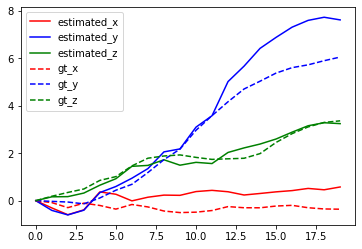

In [14]:
plt.plot(estimated_states[:, 0], "r", label="estimated_x")
plt.plot(estimated_states[:, 1], "b", label="estimated_y")
plt.plot(estimated_states[:, 2], "g", label="estimated_z")
# plt.plot(estimated_states[:, 3], "k", label="estimated_b")
plt.plot(data.gt[:, 0], "r--", label="gt_x")
plt.plot(data.gt[:, 1], "b--", label="gt_y")
plt.plot(data.gt[:, 2], "g--", label="gt_z")
# plt.plot(data.gt[:, 3], "k--", label="gt_b")
plt.legend()

In [92]:
# x_pred, Q = dynamics_model(torch.zeros(1, config.state_dim), torch.zeros(1))
# y_pred, R = kf_measurement_model(x_pred)
# x_pred, y_pred
t = 3
vsensor_model.update_sats(data.satellite_states[t, :data.N_observations[t], :])
vsensor_model(data.observations[t, None, :data.N_observations[t]])

(tensor([[ 2.0263,  0.3196, -0.0169, -0.5114,  0.0000,  0.0000,  0.0000,  0.0000]],
        grad_fn=<CopySlices>),
 tensor([[[ 1.0082e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 1.3476e-01,  9.6505e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 1.6469e+00,  8.8733e-01,  4.7253e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-1.3495e+00, -9.1340e-01, -3.7497e+00,  3.7799e-01,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  3.1623e-03,
            0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            3.1623e-03,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  3.1623e-03,  0.0000e+0